In [25]:
import pyemma.coordinates as coords
import mdtraj as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pylab as p
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances_argmin
import sklearn
import time
from math import sqrt
import sys
import os

In [26]:
from datetime import date
from subprocess import call
start_time = time.time()
trajfile = 'C:\\Users\\data\\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\\sarscov2-10880334-no-water-no-ion-glueCA\\Mpro_traj (25).dcd'
topfile = 'C:\\Users\\data\\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\\sarscov2-10880334-no-water-no-ion-glueCA\\Mpro.pdb'
project_dir = os.path.dirname(os.getcwd()) + "\\data\\"

In [27]:
traj = md.load(trajfile[:], stride=1, top=topfile)
feat = coords.featurizer(topfile)
# just use all xyz-coordinates
feat.add_all()
inp = coords.source(trajfile, feat)

In [28]:
def optimal_number_of_clusters(wcss):
    # Function to define the optimal number of clusters
    x1, y1 = 1, wcss[0]
    x2, y2 = 100, wcss[len(wcss) - 1]

    distances = []
    for i in range(len(wcss)):
        x0 = i + 2
        y0 = wcss[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        distances.append(numerator / denominator)

    return distances.index(max(distances)) + 2

In [29]:
lag = 100
tica_obj = coords.tica(inp, lag=lag, dim=2, kinetic_map=True)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
tica_components = tica_obj.fit_transform(Y) * -1
tica_components_df = pd.DataFrame(tica_components)
tica_eigenvalues = tica_obj.eigenvalues
pc_id = list(range(len(tica_eigenvalues)))
tica_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": tica_obj.cumvar, "eig_values": tica_eigenvalues})
print(tica_eigen_df)
n_tica = tica_eigen_df[tica_eigen_df['eig_cum'] <= 2]
n_tica = n_tica.shape[0]
tica_components_df = pd.DataFrame(tica_components)
X = tica_components_df.iloc[:, :n_tica]
X.shape
inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters=k, random_state=100)
    model.fit(X)
    inertias.append(model.inertia_)

n = optimal_number_of_clusters(inertias)

   pc_id  eig_cum  eig_values
0      0      0.5         1.0
1      1      1.0        -1.0


C:\Users\Mondello\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


11


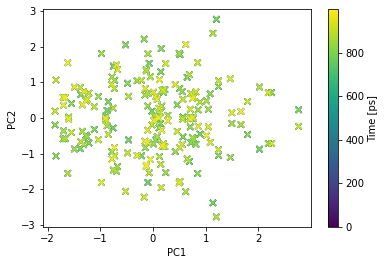

In [30]:
print(n)
plt.figure()
plt.scatter(tica_components[:, 0], tica_components[:, 1], marker='x', c=traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

<ipython-input-31-83916676f666>:13: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)


initialize kmeans++ centers:   0%|                                                             | 0/100 [00:00<…

kmeans iterations:   0%|                                                                        | 0/10 [00:00<…

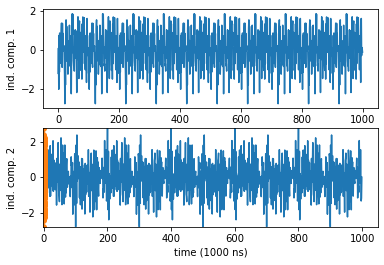

In [31]:
p.subplot2grid((2, 1), (0, 0))
p.plot(Y[:, 0])
p.ylabel('ind. comp. 1')
p.subplot2grid((2, 1), (1, 0))
p.plot(Y[:, 1])
p.ylabel('ind. comp. 2')
p.xlabel('time (1000 ns)')
p.Text(0.5, 0, 'time (1000 ns)')

# histogram data
z, x, y = np.histogram2d(Y[:, 0], Y[:, 1])
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
p.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)

cl = coords.cluster_kmeans(data=Y, k=100, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:, 0]
cc_y = cl.clustercenters[:, 1]

p.contourf(F.T, cmap=plt.cm.hot, extent=extent)
p.plot(cc_x, cc_y, linewidth=0, marker='o')

pca_obj = coords.pca(inp, dim=2)
Ypca = pca_obj.get_output()[0]

In [32]:
def _to_free_energy(z, minener_zero=False):
    pi = z / float(z.sum())
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])

    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy


def get_histogram(
        xall, yall, nbins=100,
        weights=None, avoid_zero_count=False):
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins=nbins, weights=weights)

    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])

    if avoid_zero_count:
        z = np.maximum(z, np.min(z[z.nonzero()]))
    return x, y, z.T


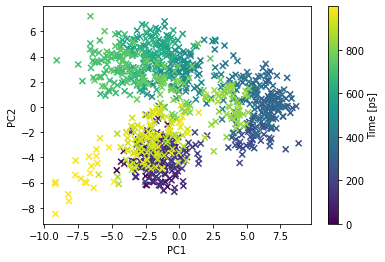

In [33]:
from sklearn.decomposition import PCA

pca_sklearn = PCA(random_state=100)
pca_components = pca_sklearn.fit_transform(Ypca) * -1
plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:, 1], marker='x', c=traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')
x, y, z = get_histogram(pca_components[:, 0], pca_components[:, 1])
plt.show()
kT = 1.0
f = _to_free_energy(z, minener_zero=True) * kT

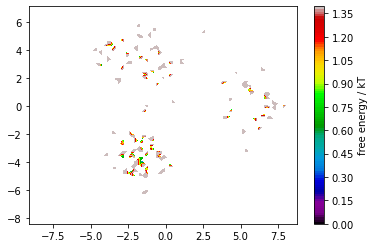

In [34]:
import matplotlib.pyplot as _plt

fig, ax = _plt.subplots()
mappable = ax.contourf(
    x, y, f, 100, norm=None,
    vmin=None, vmax=None, cmap='nipy_spectral',
    levels=None)

misc = dict(mappable=mappable)
cbar_ = fig.colorbar(
    mappable, ax=None, orientation='vertical')
cbar_.set_label('free energy / kT')

plt.show()

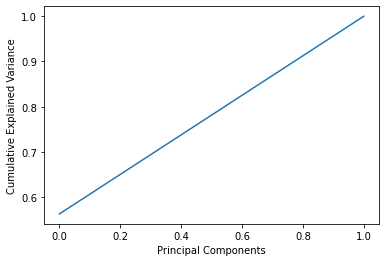

In [35]:
pca_eigenvalues = pca_sklearn.explained_variance_ratio_
pc_id = list(range(len(pca_eigenvalues)))
pca_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": np.cumsum(pca_eigenvalues), "eig_values": pca_eigenvalues})
pca_eigen_df.head()
plt.figure()
plt.plot(np.cumsum(pca_eigenvalues))
plt.xlabel("Principal Components")
plt.ylabel('Cumulative Explained Variance')
plt.show()

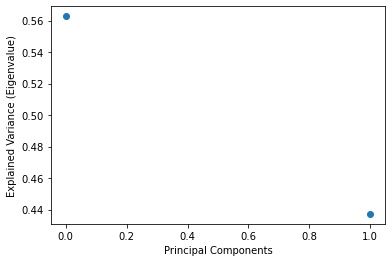

In [36]:
plt.figure()
plt.scatter(np.arange(len(pca_eigenvalues)), pca_eigenvalues)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (Eigenvalue)")
plt.show()

C:\Users\Mondello\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


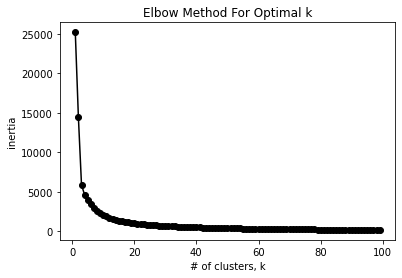

In [37]:
n_pca = pca_eigen_df[pca_eigen_df['eig_cum'] <= 2]
n_pca = n_pca.shape[0]

pca_components_df = pd.DataFrame(pca_components)

X = pca_components_df.iloc[:, :n_pca]
X.shape

inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters=k, random_state=100)
    model.fit(X)
    inertias.append(model.inertia_)
plt.figure()
plt.plot(K, inertias, '-o', color='black')
plt.xlabel('# of clusters, k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Optimal number of clusters:  10
Creation of the directory 2021-08-04 failed
Closest conformation inside cluster 0 can be found in trajectory 0 frame 997, (index 997)
mdconvert C:\Users\data\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\sarscov2-10880334-no-water-no-ion-glueCA\Mpro_traj (25).dcd -t C:\Users\data\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\sarscov2-10880334-no-water-no-ion-glueCA\Mpro.pdb -o C:\Users\data\/data/clusters/2021-08-04/PCA_in_cluster_0_997.pdb -i 997
Closest conformation inside cluster 1 can be found in trajectory 0 frame 312, (index 312)
mdconvert C:\Users\data\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\sarscov2-10880334-no-water-no-ion-glueCA\Mpro_traj (25).dcd -t C:\Users\data\DESRES-Trajectory_sarscov2-10880334-no-water-no-ion-glueCA\sarscov2-10880334-no-water-no-ion-glueCA\Mpro.pdb -o C:\Users\data\/data/clusters/2021-08-04/PCA_in_cluster_1_312.pdb -i 312
Closest conformation inside cluster 2 can be found in tr

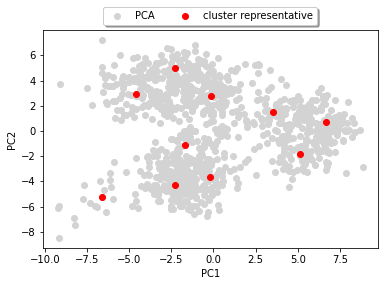

In [38]:
n = optimal_number_of_clusters(inertias)
print("Optimal number of clusters: ", n)

km = KMeans(n_clusters=n)
km = km.fit(X)

OPTIONAL = True
execution = date.today().strftime('%Y-%m-%d')

closest = pairwise_distances_argmin(km.cluster_centers_, X)
representatives = []

try:
    os.makedirs(os.path.join(project_dir + "/data/" + "clusters", execution))
except OSError:
    print("Creation of the directory %s failed" % execution)
else:
    print("Successfully created the directory %s " % execution)
for i in enumerate(closest):
    traj_index = int((i[1] - 1) / traj.n_frames)
    frame_index = i[1] - (traj_index * traj.n_frames)

    n_cluster = str(i[0])

    representatives.append([traj_index, frame_index, i[1]])
    print(
        f"Closest conformation inside cluster {n_cluster} can be found in trajectory {traj_index} frame {frame_index}, (index {i[1]})")
    if OPTIONAL:
        convert_command = f"mdconvert {trajfile} -t {topfile} -o {project_dir}/data/clusters/{execution}/PCA_in_cluster_{n_cluster}_{frame_index}.pdb -i {frame_index}"
        print(convert_command)

        call(convert_command, shell=True)
plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:, 1], c="lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

[plt.scatter(pca_components[yr[2], 0], pca_components[yr[2], 1], c="red") for yr in representatives]

plt.legend(["PCA", "cluster representative"], loc='upper center', bbox_to_anchor=(0.5, 1.13), fancybox=True,
           shadow=True, ncol=5)
plt.show()


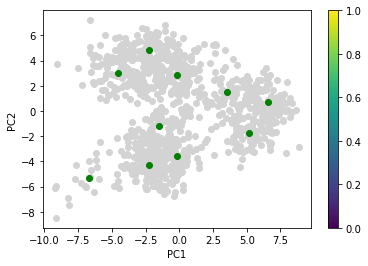

In [39]:
cc = km.cluster_centers_
# plotting all elements
plt.figure()
plt.scatter(pca_components_df.iloc[:, 0], pca_components_df.iloc[:, 1], c="lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

# plotting cluster centers
plt.scatter(cc[:, 0], cc[:, 1], c="green")
plt.colorbar()
plt.show()